# Exp NBD: DONE

In [1]:
import numpy as np

with open("g7.td") as f:
    for i, line in enumerate(f):
        if line.strip() == "#DATA":
            start = i + 1
            break

data = np.loadtxt("g7.td", skiprows=start)
print(data[:5])
print(data[-5:])

# time [s]
# Intensity Floureszenz

print(data.shape)

[[ 0.2      94.535   ]
 [ 0.4      94.264333]
 [ 0.6      94.262666]
 [ 0.8      94.379666]
 [ 1.       94.208666]]
[[5399.4       172.133   ]
 [5399.6       171.97    ]
 [5399.8       171.989   ]
 [5400.        172.068333]
 [5400.2       172.376   ]]
(27001, 2)


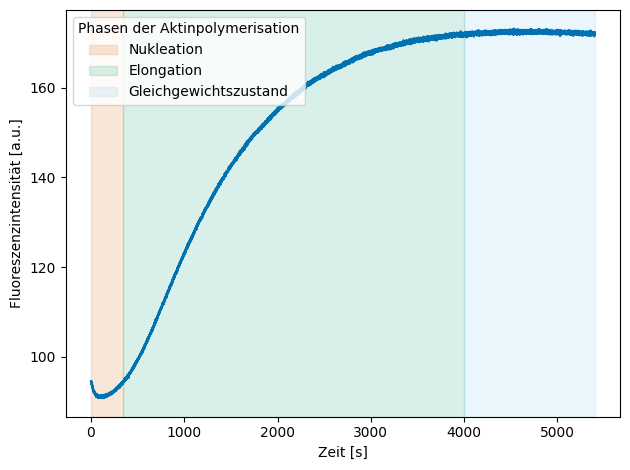

In [2]:
import matplotlib.pyplot as plt

x = data[:, 0]
y = data[:, 1]

plt.figure()
plt.plot(x, y, color="#0072B2", label="Messdaten")

# ---- FARBBEREICHE ----
lag = plt.axvspan(0, 343, color='#D55E00', alpha=0.15, label="Nukleation")
exp = plt.axvspan(343, 4000, color='#009E73', alpha=0.15, label="Elongation")
plateau = plt.axvspan(4000, 5400, color='#56B4E9', alpha=0.12, label="Gleichgewichtszustand")

# ---- ACHSEN ----
plt.xlabel("Zeit [s]")
plt.ylabel("Fluoreszenzintensität [a.u.]")

# ---- LEGENDE ----
plt.legend(handles=[lag, exp, plateau], loc="upper left", title="Phasen der Aktinpolymerisation")

plt.tight_layout()
plt.show()

#"Exponentielle Phase, Sättigungphase

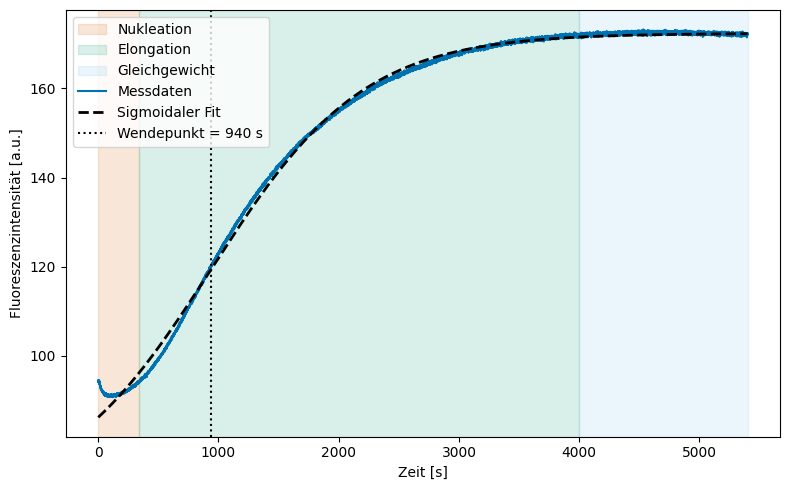

Fit-Parameter:
A  (Baseline)        = 66.59
K  (Amplitude)       = 105.76
r  (Rate)            = 1.5733e-03 1/s
t0 (Wendepunkt)      = 939.6 s

Steigung am Wendepunkt = 0.042 a.u./s
R² = 0.9981


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -------------------------------------------------
# Daten einlesen
# -------------------------------------------------
with open("g7.td") as f:
    for i, line in enumerate(f):
        if line.strip() == "#DATA":
            start = i + 1
            break

data = np.loadtxt("g7.td", skiprows=start)

x = data[:, 0]   # Zeit [s]
y = data[:, 1]   # Fluoreszenz [a.u.]

# -------------------------------------------------
# Sigmoid-Funktion (logistisch)
# -------------------------------------------------
def sigmoid(t, A, K, r, t0):
    return A + K / (1 + np.exp(-r * (t - t0)))

# -------------------------------------------------
# Initialwerte (wichtig für flache Nukleation!)
# -------------------------------------------------
A0 = np.min(y)
K0 = np.max(y) - np.min(y)
r0 = 0.002           # bewusst klein → flache Startphase
t0_0 = 1500          # grober Wendepunkt

p0 = [A0, K0, r0, t0_0]

# -------------------------------------------------
# Fit
# -------------------------------------------------
params, cov = curve_fit(sigmoid, x, y, p0=p0, maxfev=10000)
A, K, r, t0 = params

y_fit = sigmoid(x, A, K, r, t0)

# -------------------------------------------------
# Steigung im Wendepunkt
# -------------------------------------------------
slope_inflection = K * r / 4

# -------------------------------------------------
# R² berechnen
# -------------------------------------------------
residuals = y - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - ss_res / ss_tot

# -------------------------------------------------
# Plot
# -------------------------------------------------
plt.figure(figsize=(8,5))

# Phasen
lag = plt.axvspan(0, 343, color='#D55E00', alpha=0.15, label="Nukleation")
exp = plt.axvspan(343, 4000, color='#009E73', alpha=0.15, label="Elongation")
plateau = plt.axvspan(4000, 5400, color='#56B4E9', alpha=0.12, label="Gleichgewicht")

# Daten + Fit
plt.plot(x, y, color="#0072B2", label="Messdaten")
plt.plot(x, y_fit, "k--", linewidth=2, label="Sigmoidaler Fit")

# Wendepunkt
plt.axvline(t0, color="k", linestyle=":", label=f"Wendepunkt = {t0:.0f} s")

plt.xlabel("Zeit [s]")
plt.ylabel("Fluoreszenzintensität [a.u.]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Ausgabe
# -------------------------------------------------
print("Fit-Parameter:")
print(f"A  (Baseline)        = {A:.2f}")
print(f"K  (Amplitude)       = {K:.2f}")
print(f"r  (Rate)            = {r:.4e} 1/s")
print(f"t0 (Wendepunkt)      = {t0:.1f} s")
print()
print(f"Steigung am Wendepunkt = {slope_inflection:.3f} a.u./s")
print(f"R² = {r_squared:.4f}")


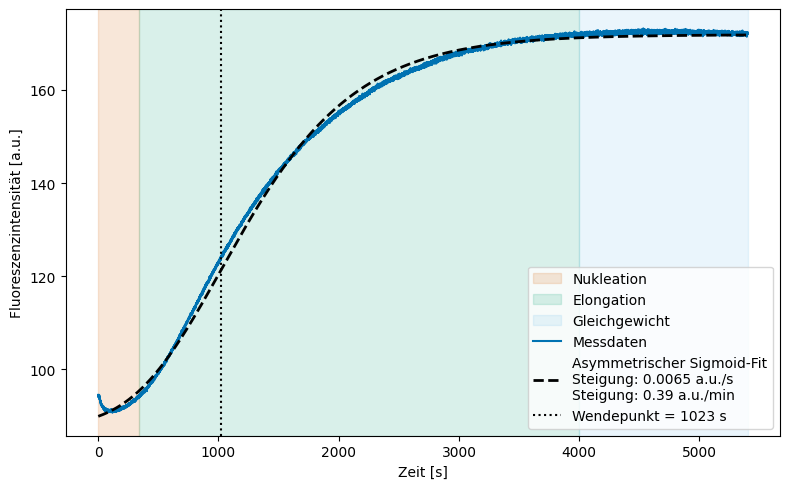

Fit-Parameter (gewichtete Richards-Kurve):
A   (Baseline)        = 87.75
K   (Amplitude)       = 84.12
r   (Rate)            = 1.6263e-03 1/s
t0  (Fit-Zentrum)     = 0.0 s
nu  (Asymmetrie)      = 5.28

Wendepunkt            = 1022.7 s
Steigung dort         = 0.006 a.u./s
R²                    = 0.9979


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -------------------------------------------------
# Daten einlesen
# -------------------------------------------------
with open("g7.td") as f:
    for i, line in enumerate(f):
        if line.strip() == "#DATA":
            start = i + 1
            break

data = np.loadtxt("g7.td", skiprows=start)

x = data[:, 0]   # Zeit [s]
y = data[:, 1]   # Fluoreszenz [a.u.]

# -------------------------------------------------
# Asymmetrische Sigmoidfunktion (Richards)
# -------------------------------------------------
def richards(t, A, K, r, t0, nu):
    return A + K / (1 + np.exp(-r * (t - t0)))**nu

# -------------------------------------------------
# Startwerte
# -------------------------------------------------
A0 = np.min(y)
K0 = np.max(y) - np.min(y)
r0 = 0.002
t0_0 = 1200
nu0 = 2.0

p0 = [A0, K0, r0, t0_0, nu0]

# -------------------------------------------------
# Gewichtung: Nukleationsphase stärker
# -------------------------------------------------
sigma = np.ones_like(y)
sigma[(x >= 0) & (x <= 343)] = 0.25   # kleiner = höheres Gewicht

# -------------------------------------------------
# Fit
# -------------------------------------------------
params, cov = curve_fit(
    richards, x, y,
    p0=p0,
    sigma=sigma,
    absolute_sigma=False,
    bounds=(
        [0, 0, 0, 0, 1.0],
        [np.inf, np.inf, 1.0, 6000, 10.0]
    ),
    maxfev=40000
)

A, K, r, t0, nu = params
y_fit = richards(x, A, K, r, t0, nu)

# -------------------------------------------------
# Wendepunkt & Steigung
# -------------------------------------------------
t_inflection = t0 + np.log(nu) / r
slope_inflection = K * r / (4 * nu)

# -------------------------------------------------
# R²
# -------------------------------------------------
ss_res = np.sum((y - y_fit)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - ss_res / ss_tot

# -------------------------------------------------
# Plot
# -------------------------------------------------
plt.figure(figsize=(8,5))

lag = plt.axvspan(0, 343, color='#D55E00', alpha=0.15, label="Nukleation")
exp = plt.axvspan(343, 4000, color='#009E73', alpha=0.15, label="Elongation")
plateau = plt.axvspan(4000, 5400, color='#56B4E9', alpha=0.12, label="Gleichgewicht")
slope_s = slope_inflection                 # a.u./s
slope_min = slope_inflection * 60          # a.u./min


plt.plot(x, y, color="#0072B2", label="Messdaten")
plt.plot(
    x, y_fit,
    "k--",
    linewidth=2,
    label=(
        "Asymmetrischer Sigmoid-Fit\n"
        f"Steigung: {slope_s:.4f} a.u./s\n"
        f"Steigung: {slope_min:.2f} a.u./min"
    )
)

plt.axvline(t_inflection, color="k", linestyle=":",
            label=f"Wendepunkt = {t_inflection:.0f} s")

plt.xlabel("Zeit [s]")
plt.ylabel("Fluoreszenzintensität [a.u.]")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Ausgabe
# -------------------------------------------------
print("Fit-Parameter (gewichtete Richards-Kurve):")
print(f"A   (Baseline)        = {A:.2f}")
print(f"K   (Amplitude)       = {K:.2f}")
print(f"r   (Rate)            = {r:.4e} 1/s")
print(f"t0  (Fit-Zentrum)     = {t0:.1f} s")
print(f"nu  (Asymmetrie)      = {nu:.2f}")
print()
print(f"Wendepunkt            = {t_inflection:.1f} s")
print(f"Steigung dort         = {slope_inflection:.3f} a.u./s")
print(f"R²                    = {r_squared:.4f}")


In [5]:
# Steigung am Wendepunkt
slope_inflection = K * r / (4 * nu)        # a.u./s
slope_inflection_min = slope_inflection * 60  # a.u./min

print(f"Steigung am Wendepunkt = {slope_inflection:.4f} a.u./s")
print(f"Steigung am Wendepunkt = {slope_inflection_min:.2f} a.u./min")


Steigung am Wendepunkt = 0.0065 a.u./s
Steigung am Wendepunkt = 0.39 a.u./min


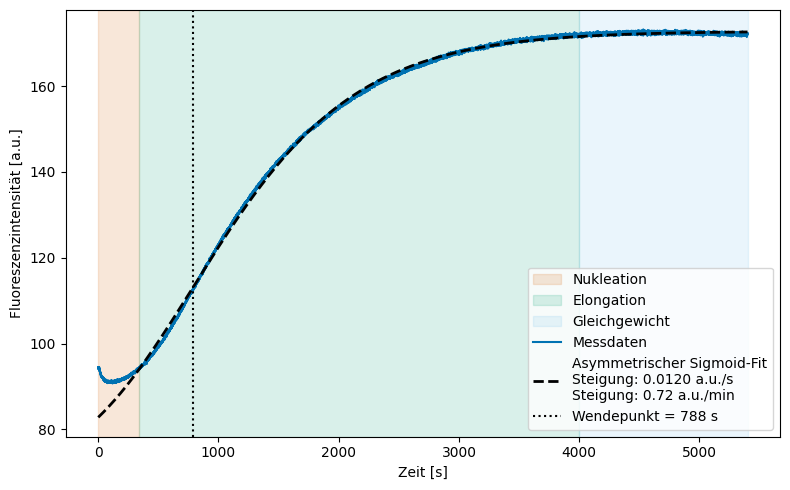

Asymmetrischer Sigmoid-Fit (Artefaktbereich ausgeschlossen)
A   (Baseline)        = 69.40
K   (Amplitude)       = 103.42
r   (Rate)            = 1.3710e-03 1/s
t0  (Fit-Zentrum)     = 0.0 s
nu  (Asymmetrie)      = 2.95

Wendepunkt            = 788.0 s
Steigung dort         = 0.0120 a.u./s
Steigung dort         = 0.72 a.u./min
R² (Fit-Bereich)      = 0.9994


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -------------------------------------------------
# Daten einlesen
# -------------------------------------------------
with open("g7.td") as f:
    for i, line in enumerate(f):
        if line.strip() == "#DATA":
            start = i + 1
            break

data = np.loadtxt("g7.td", skiprows=start)

x = data[:, 0]   # Zeit [s]
y = data[:, 1]   # Fluoreszenz [a.u.]

# -------------------------------------------------
# Asymmetrische Sigmoidfunktion (Richards)
# -------------------------------------------------
def richards(t, A, K, r, t0, nu):
    return A + K / (1 + np.exp(-r * (t - t0)))**nu

# -------------------------------------------------
# Anfangsdip ausschließen (physikalisch korrekt)
# -------------------------------------------------
fit_mask = x >= 200   # alles davor ist Artefakt (Mischen / Relaxation)

# -------------------------------------------------
# Startwerte
# -------------------------------------------------
A0 = np.min(y[fit_mask])
K0 = np.max(y[fit_mask]) - np.min(y[fit_mask])
r0 = 0.002
t0_0 = 1200
nu0 = 2.0

p0 = [A0, K0, r0, t0_0, nu0]

# -------------------------------------------------
# Fit (nur Polymerisationsbereich!)
# -------------------------------------------------
params, cov = curve_fit(
    richards,
    x[fit_mask],
    y[fit_mask],
    p0=p0,
    bounds=(
        [0, 0, 0, 0, 1.0],
        [np.inf, np.inf, 1.0, 6000, 5.0]
    ),
    maxfev=40000
)

A, K, r, t0, nu = params

# Fit über gesamte Zeit darstellen
y_fit = richards(x, A, K, r, t0, nu)

# -------------------------------------------------
# Wendepunkt & Steigung
# -------------------------------------------------
t_inflection = t0 + np.log(nu) / r
slope_sec = K * r / (4 * nu)        # a.u./s
slope_min = slope_sec * 60          # a.u./min

# -------------------------------------------------
# R² (nur im Fit-Bereich!)
# -------------------------------------------------
y_fit_masked = richards(x[fit_mask], A, K, r, t0, nu)
ss_res = np.sum((y[fit_mask] - y_fit_masked)**2)
ss_tot = np.sum((y[fit_mask] - np.mean(y[fit_mask]))**2)
r_squared = 1 - ss_res / ss_tot

# -------------------------------------------------
# Plot
# -------------------------------------------------
plt.figure(figsize=(8,5))

# Phasen
plt.axvspan(0, 343, color='#D55E00', alpha=0.15, label="Nukleation")
plt.axvspan(343, 4000, color='#009E73', alpha=0.15, label="Elongation")
plt.axvspan(4000, 5400, color='#56B4E9', alpha=0.12, label="Gleichgewicht")

# Daten & Fit
plt.plot(x, y, color="#0072B2", label="Messdaten")
plt.plot(
    x, y_fit,
    "k--", linewidth=2,
    label=(
        "Asymmetrischer Sigmoid-Fit\n"
        f"Steigung: {slope_sec:.4f} a.u./s\n"
        f"Steigung: {slope_min:.2f} a.u./min"
    )
)

# Wendepunkt
plt.axvline(
    t_inflection,
    color="k", linestyle=":",
    label=f"Wendepunkt = {t_inflection:.0f} s"
)

plt.xlabel("Zeit [s]")
plt.ylabel("Fluoreszenzintensität [a.u.]")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Ausgabe
# -------------------------------------------------
print("Asymmetrischer Sigmoid-Fit (Artefaktbereich ausgeschlossen)")
print(f"A   (Baseline)        = {A:.2f}")
print(f"K   (Amplitude)       = {K:.2f}")
print(f"r   (Rate)            = {r:.4e} 1/s")
print(f"t0  (Fit-Zentrum)     = {t0:.1f} s")
print(f"nu  (Asymmetrie)      = {nu:.2f}")
print()
print(f"Wendepunkt            = {t_inflection:.1f} s")
print(f"Steigung dort         = {slope_sec:.4f} a.u./s")
print(f"Steigung dort         = {slope_min:.2f} a.u./min")
print(f"R² (Fit-Bereich)      = {r_squared:.4f}")


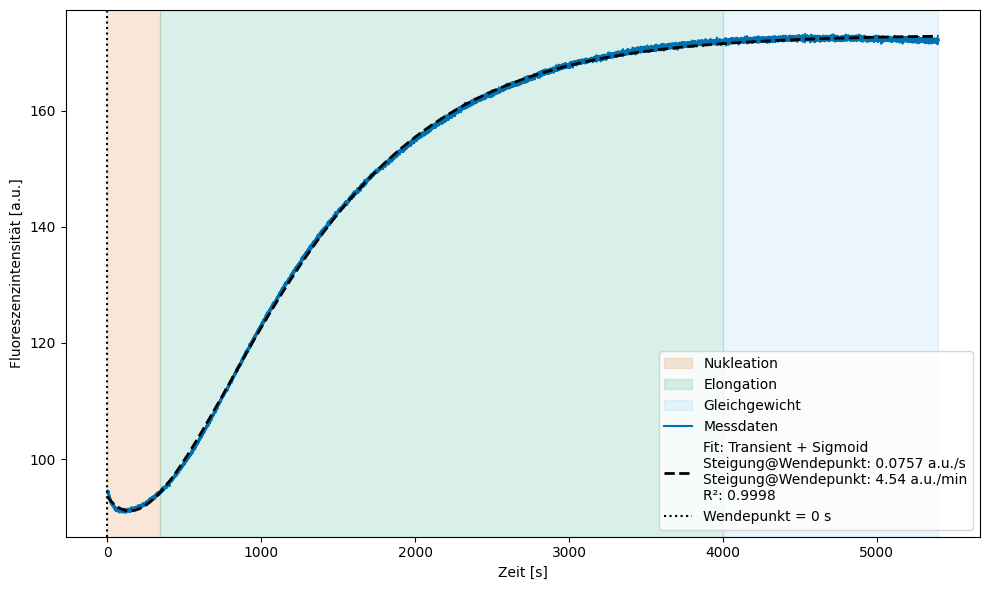

Fit-Parameter (Transient + Richards):
A   (Baseline)           = -66.944
B   (Transient-Amplitude)= 40.472
tau (Transient-Zeit)     = 359.7 s
K   (Sigmoid-Amplitude)  = 240.040
r   (Rate)               = 1.2622e-03 1/s
t0  (Fit-Zentrum)        = 0.0 s
nu  (Asymmetrie)         = 1.000

Wendepunkt               = 0.0 s
Steigung dort            = 0.0757 a.u./s  = 4.54 a.u./min
R² (gesamt)              = 0.9998


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -------------------------------------------------
# Daten einlesen
# -------------------------------------------------
with open("g7.td") as f:
    for i, line in enumerate(f):
        if line.strip() == "#DATA":
            start = i + 1
            break

data = np.loadtxt("g7.td", skiprows=start)
x = data[:, 0]   # Zeit [s]
y = data[:, 1]   # Fluoreszenz [a.u.]

# -------------------------------------------------
# Modell: Transient (Dip) + asymmetrischer Sigmoid (Richards)
# -------------------------------------------------
def model(t, A, B, tau, K, r, t0, nu):
    # A: Baseline
    # B,tau: exponentieller Transient am Anfang (Dip/Relaxation)
    # K,r,t0,nu: Richards-Sigmoid für Polymerisation
    return A + B * np.exp(-t / tau) + K / (1 + np.exp(-r * (t - t0)))**nu

# -------------------------------------------------
# Startwerte (robust)
# -------------------------------------------------
A0 = np.min(y)
K0 = np.max(y) - np.min(y)
B0 = y[0] - y[50] if len(y) > 50 else (y[0] - A0)   # grober Dip
tau0 = 150.0                                        # Sekunden, grob
r0 = 0.002
t0_0 = 1200.0
nu0 = 2.0

p0 = [A0, B0, tau0, K0, r0, t0_0, nu0]

# -------------------------------------------------
# Gewichte: Anfang (Lag) stärker gewichten, aber nicht übertreiben
# (kleiner sigma = mehr Gewicht)
# -------------------------------------------------
sigma = np.ones_like(y)
sigma[(x >= 0) & (x <= 343)] = 0.4     # Lag-Phase wichtiger
sigma[(x > 343) & (x <= 1200)] = 0.7   # früher Anstieg auch wichtig

# -------------------------------------------------
# Fit mit Grenzen (damit tau nicht völlig entgleist)
# -------------------------------------------------
bounds_lower = [-np.inf, -np.inf,   1.0,   0.0, 0.0,   0.0, 1.0]
bounds_upper = [ np.inf,  np.inf, 800.0, np.inf, 1.0, 6000.0, 8.0]

params, cov = curve_fit(
    model, x, y,
    p0=p0,
    sigma=sigma,
    absolute_sigma=False,
    bounds=(bounds_lower, bounds_upper),
    maxfev=80000
)

A, B, tau, K, r, t0, nu = params
y_fit = model(x, *params)

# -------------------------------------------------
# Wendepunkt & Steigung des Richards-Teils (Polymerisationsteil)
# (Transient ignorieren wir für "Polymerisationsrate")
# -------------------------------------------------
t_inflection = t0 + np.log(nu) / r
slope_sec = (K * r) / (4 * nu)         # a.u./s
slope_min = slope_sec * 60             # a.u./min

# -------------------------------------------------
# R² (gesamt, über alle Daten)
# -------------------------------------------------
ss_res = np.sum((y - y_fit)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - ss_res / ss_tot

# -------------------------------------------------
# Plot
# -------------------------------------------------
plt.figure(figsize=(10,6))

plt.axvspan(0, 343, color='#D55E00', alpha=0.15, label="Nukleation")
plt.axvspan(343, 4000, color='#009E73', alpha=0.15, label="Elongation")
plt.axvspan(4000, 5400, color='#56B4E9', alpha=0.12, label="Gleichgewicht")

plt.plot(x, y, color="#0072B2", label="Messdaten")
plt.plot(
    x, y_fit, "k--", linewidth=2,
    label=(
        "Fit: Transient + Sigmoid\n"
        f"Steigung@Wendepunkt: {slope_sec:.4f} a.u./s\n"
        f"Steigung@Wendepunkt: {slope_min:.2f} a.u./min\n"
        f"R²: {r_squared:.4f}"
    )
)

plt.axvline(t_inflection, color="k", linestyle=":", label=f"Wendepunkt = {t_inflection:.0f} s")

plt.xlabel("Zeit [s]")
plt.ylabel("Fluoreszenzintensität [a.u.]")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Ausgabe
# -------------------------------------------------
print("Fit-Parameter (Transient + Richards):")
print(f"A   (Baseline)           = {A:.3f}")
print(f"B   (Transient-Amplitude)= {B:.3f}")
print(f"tau (Transient-Zeit)     = {tau:.1f} s")
print(f"K   (Sigmoid-Amplitude)  = {K:.3f}")
print(f"r   (Rate)               = {r:.4e} 1/s")
print(f"t0  (Fit-Zentrum)        = {t0:.1f} s")
print(f"nu  (Asymmetrie)         = {nu:.3f}")
print()
print(f"Wendepunkt               = {t_inflection:.1f} s")
print(f"Steigung dort            = {slope_sec:.4f} a.u./s  = {slope_min:.2f} a.u./min")
print(f"R² (gesamt)              = {r_squared:.4f}")


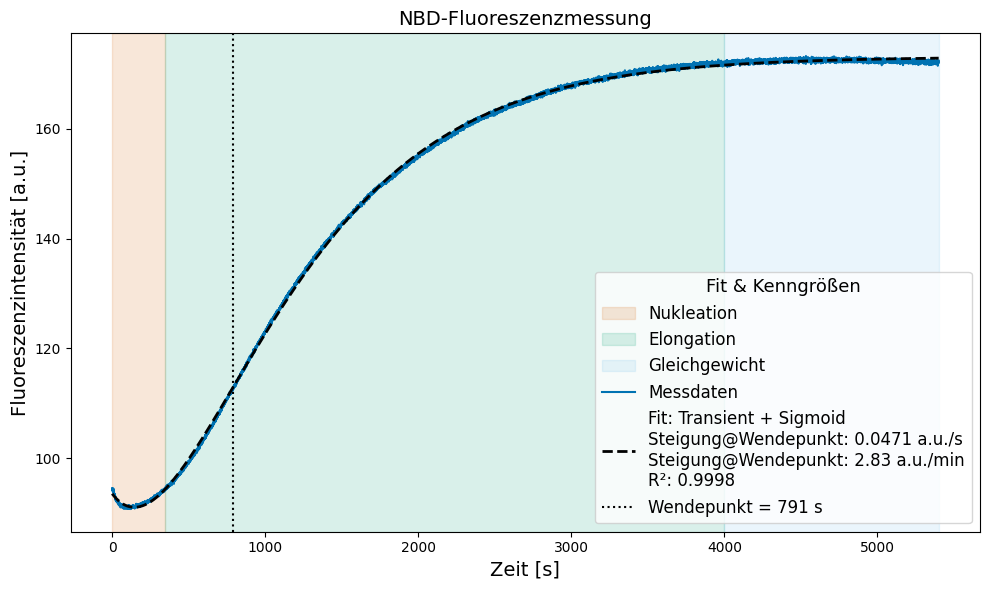

Fit-Parameter (Transient + Richards):
A   = -66.944
B   = 40.472
tau = 359.7 s
K   = 240.040
r   = 1.2622e-03 1/s
t0  = 0.0 s
nu  = 1.000

Wendepunkt (max dI/dt im Fenster 343-4000s) = 790.8 s
Steigung dort = 0.0471 a.u./s = 2.83 a.u./min
R² (gesamt)   = 0.9998


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -------------------------------------------------
# Daten einlesen
# -------------------------------------------------
with open("g7.td") as f:
    for i, line in enumerate(f):
        if line.strip() == "#DATA":
            start = i + 1
            break

data = np.loadtxt("g7.td", skiprows=start)
x = data[:, 0]   # Zeit [s]
y = data[:, 1]   # Fluoreszenz [a.u.]

# -------------------------------------------------
# Modell: Transient + Richards-Sigmoid
# -------------------------------------------------
def model(t, A, B, tau, K, r, t0, nu):
    return A + B * np.exp(-t / tau) + K / (1 + np.exp(-r * (t - t0)))**nu

# -------------------------------------------------
# Startwerte
# -------------------------------------------------
A0 = np.min(y)
K0 = np.max(y) - np.min(y)
B0 = y[0] - y[50] if len(y) > 50 else (y[0] - A0)
tau0 = 150.0
r0 = 0.002
t0_0 = 1200.0
nu0 = 2.0

p0 = [A0, B0, tau0, K0, r0, t0_0, nu0]

# -------------------------------------------------
# Gewichtung: Lag-Phase wichtig
# -------------------------------------------------
sigma = np.ones_like(y)
sigma[(x >= 0) & (x <= 343)] = 0.4
sigma[(x > 343) & (x <= 1200)] = 0.7

# -------------------------------------------------
# Fit mit Bounds
# -------------------------------------------------
bounds_lower = [-np.inf, -np.inf,   1.0,   0.0, 0.0,   0.0, 1.0]
bounds_upper = [ np.inf,  np.inf, 800.0, np.inf, 1.0, 6000.0, 8.0]

params, cov = curve_fit(
    model, x, y,
    p0=p0,
    sigma=sigma,
    absolute_sigma=False,
    bounds=(bounds_lower, bounds_upper),
    maxfev=80000
)

A, B, tau, K, r, t0, nu = params
y_fit = model(x, *params)

# -------------------------------------------------
# Wendepunkt + Steigung ROBUST:
# Maximum der Steigung des FITS im Elongationsfenster
# -------------------------------------------------
t_grid = np.linspace(x.min(), x.max(), 20000)
y_grid = model(t_grid, *params)

dy_dt = np.gradient(y_grid, t_grid)  # numerische Ableitung

# Suchfenster: Elongation (anpassen, wenn du willst)
t_low, t_high = 343, 4000
mask = (t_grid >= t_low) & (t_grid <= t_high)

idx = np.argmax(dy_dt[mask])
t_inflection = t_grid[mask][idx]
slope_sec = dy_dt[mask][idx]
slope_min = slope_sec * 60

# R² über alle Daten
ss_res = np.sum((y - y_fit)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - ss_res / ss_tot

# -------------------------------------------------
# Plot
# -------------------------------------------------
plt.figure(figsize=(10,6))

plt.axvspan(0, 343, color='#D55E00', alpha=0.15, label="Nukleation")
plt.axvspan(343, 4000, color='#009E73', alpha=0.15, label="Elongation")
plt.axvspan(4000, 5400, color='#56B4E9', alpha=0.12, label="Gleichgewicht")

plt.plot(x, y, color="#0072B2", label="Messdaten")
plt.plot(
    x, y_fit, "k--", linewidth=2,
    label=(
        "Fit: Transient + Sigmoid\n"
        f"Steigung@Wendepunkt: {slope_sec:.4f} a.u./s\n"
        f"Steigung@Wendepunkt: {slope_min:.2f} a.u./min\n"
        f"R²: {r_squared:.4f}"
    )
)

plt.axvline(t_inflection, color="k", linestyle=":", label=f"Wendepunkt = {t_inflection:.0f} s")

plt.title("NBD-Fluoreszenzmessung", fontsize=14)

plt.xlabel("Zeit [s]", fontsize=14)
plt.ylabel("Fluoreszenzintensität [a.u.]", fontsize=14)
plt.legend(
    loc="lower right",
    fontsize=12,
    title="Fit & Kenngrößen",
    title_fontsize=13,
    frameon=True
)

plt.tight_layout()
plt.show()

# -------------------------------------------------
# Ausgabe
# -------------------------------------------------
print("Fit-Parameter (Transient + Richards):")
print(f"A   = {A:.3f}")
print(f"B   = {B:.3f}")
print(f"tau = {tau:.1f} s")
print(f"K   = {K:.3f}")
print(f"r   = {r:.4e} 1/s")
print(f"t0  = {t0:.1f} s")
print(f"nu  = {nu:.3f}")
print()
print(f"Wendepunkt (max dI/dt im Fenster {t_low}-{t_high}s) = {t_inflection:.1f} s")
print(f"Steigung dort = {slope_sec:.4f} a.u./s = {slope_min:.2f} a.u./min")
print(f"R² (gesamt)   = {r_squared:.4f}")


In [ ]:
# New Plotting
